# Assignment 3 - Organized Code File



###  i). Import libraries

In [798]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostClassifier, cv
import warnings
warnings.filterwarnings('ignore')


sns.set(style="darkgrid")

### ii).  Read csv data 

In [800]:
general_payments = pd.read_csv('PGYR17_P011819/OP_DTL_GNRL_PGYR2017_P01182019.csv')
#payments or other transfers of value made to a covered recipient (physician or teaching hospital) that are not made in connection with a research agreement or research protocol.     

research_payments = pd.read_csv('PGYR17_P011819/OP_DTL_RSRCH_PGYR2017_P01182019.csv')
#research agreement

ownership_info = pd.read_csv('PGYR17_P011819/OP_DTL_OWNRSHP_PGYR2017_P01182019.csv')
#investment interests that a physician or an immediate family member of a physician held in an applicable manufacturer or applicable group purchasing organization (GPO).

deleted_payments = pd.read_csv('PGYR17_P011819/OP_REMOVED_DELETED_PGYR2017_P01182019.csv')
#deleted records published previously


## Task 0 :: Get a Final Dataset Table

###  i). Delete empty columns (columns with less than 50% data)

In [3]:
nrow,ncol = general_payments.shape
drop_indices = list()
for i in range(ncol):
    if general_payments.iloc[:,i].isna().sum()/nrow >0.5:
        drop_indices.append(i)

general_payments = general_payments.drop(general_payments.columns[drop_indices], axis=1)

nrow,ncol = research_payments.shape
drop_indices = list()
for i in range(ncol):
    if research_payments.iloc[:,i].isna().sum()/nrow >0.5:
        drop_indices.append(i)
research_payments = research_payments.drop(research_payments.columns[drop_indices], axis=1)

#repeated (with different names) columns drop
drop_columns = ['Principal_Investigator_1_City','Principal_Investigator_1_State','Principal_Investigator_1_Zip_Code','Principal_Investigator_1_Country']
research_payments = research_payments.drop(drop_columns,axis=1)


Sparse columns were removed in the interest of building better prediction and obtaining a smaller set of relatively complete features. 

Also, going by the data dictionary, the columns of Principal Investigator (which take up the same values as Recipient/Physician for city/state/country, etc) were dropped. The rationale will further be explained in the next step.

### ii). Rename columns for consistency across tables before merge

In [4]:
for name in list(research_payments):
    research_payments = research_payments.rename(index=str,columns={name:name.replace('Principal_Investigator_1','Physician')})
    research_payments = research_payments.rename(index=str,columns={name:name.replace('Recipient','Physician')})
for name in list(general_payments):
    general_payments = general_payments.rename(index=str,columns={name:name.replace('Recipient','Physician')})
    

Going by the data dictionary, we see that the terms Recipient, Principal Invesigator and Physician refer to the same person in different circumstances. Eg. The physician is referred to as "recipient" in the 'Research Payments' table. 

Also, the 'Principal Investigator' has the same values as the Physician in the Research Payments. 

### iii). Drop useless columns (like names, addresses) before merge

In [5]:
drop_columns = list(set(list(research_payments))-set(list(set(list(research_payments)).intersection(list(general_payments)))))
research_payments = research_payments.drop(drop_columns,axis=1)

drop_columns = list(set(list(general_payments))-set(list(set(list(research_payments)).intersection(list(general_payments)))))
general_payments = general_payments.drop(drop_columns,axis=1)

#research_payments = research_payments.drop_duplicates(keep=False,inplace=True)       
           

A few columns that don't make good potential features (like Address, Name, etc) are removed. Too many categories would lead to very sparse matrices after one-hot encoding with little to no statistical significance.

### iv). Add column "type" to differentiate between general and research payments

In [427]:
general_payments['type'] = 0
research_payments['type'] = 1

The "type" variable acts as our differentiator once we append the tables. A type 0 indicates general, type 1 indicates research.

**The two tables (general and research payments) are now ready to be merged. This will serve as our base dataset, and we'll identify prominent feature, drop leaky (indicating target) features, and engineer more features.**

In [428]:
result = general_payments.append(research_payments)

## Task 1 : Identify Features


We will explore our columns and identify strong features. Some features leaking target info need to be removed.

A subset of 10k records is taken from the data. The percentage distribution of categories (research and general) was found to be around the same.

['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Change_Type',
 'Covered_Physician_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Date_of_Payment',
 'Delay_in_Publication_Indicator',
 'Dispute_Status_for_Publication',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Payment_Publication_Date',
 'Physician_City',
 'Physician_Country',
 'Physician_First_Name',
 'Physician_Last_Name',
 'Physician_License_State_code1',
 'Physician_Middle_Name',
 'Physician_Primary_Business_Street_Address_Line1',
 'Physician_Primary_Type',
 'Physician_Profile_ID',
 'Physician_Specialty',
 'Physician_State',
 'Physician_Zip_Code',
 'Product_Category_or_Therapeutic_Area_1',
 'Prog

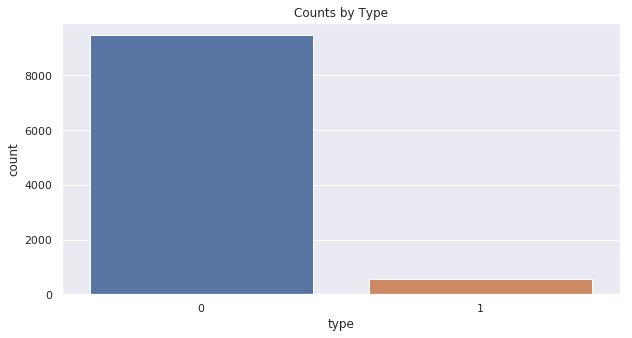

In [864]:
res = result.sample(n=10000, random_state=1)
ax = sns.countplot(x="type", data=res).set_title("Counts by Type")
list(result)

The features for our combined table are printed - and a countplot for our type variable is printed. 

We can clearly see the imbalance in categories, type 0 is over represented in our data. We'll handle this in the later sections.

**Let us start exploring our predictor columns to find strong features and remove poor predictors.**

We'll start with "Covered_Physician_Type"

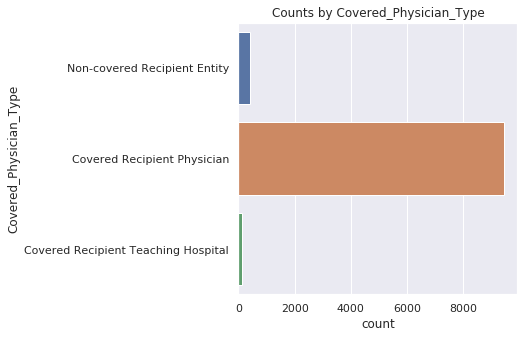

In [802]:
from random import sample
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.countplot(y='Covered_Physician_Type', data=res).set_title("Counts by Covered_Physician_Type")

A countplot shows that most physicians (around 95%) come in the **Covered Recipient Physician** category. It would be interesting to identify the what proportion of transactions are research transactions for each of these categories.

Text(0.5, 1.0, 'Covered Physician Type vs Number of General Payment counts')

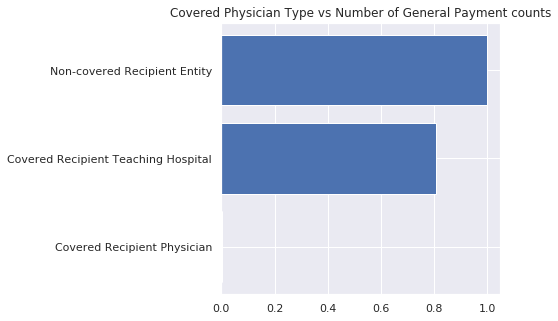

In [803]:
r = res.groupby('Covered_Physician_Type')['type'].agg(np.mean).reset_index()
plt.barh(r['Covered_Physician_Type'],r['type'])
plt.title('Covered Physician Type vs Number of General Payment counts')

A whopping 100% entries of the **Covered Recipient Physician** are in the General Category. This, on top of the fact that around 95% of the values belong to this category makes it a leaky feature and must be dropped.

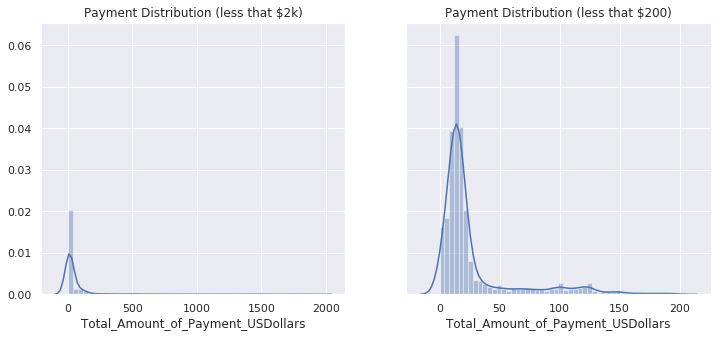

In [804]:
sns.set(rc={'figure.figsize':(12,5)})
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
r = res[res.Total_Amount_of_Payment_USDollars<2000]
ax = sns.distplot(r.Total_Amount_of_Payment_USDollars,ax=ax1).set_title('Payment Distribution (less that $2k)')

r = res[res.Total_Amount_of_Payment_USDollars<200]
ax = sns.distplot(r.Total_Amount_of_Payment_USDollars,ax=ax2).set_title('Payment Distribution (less that $200)')


A histogram for the Total Payment in USD (less that 2k dollars) shows us that a vast majority of the payments are less that $200. It would be better to focus on this distribution.

Let us observe the payment distribution for different types. A boxplot will be quite insightful.

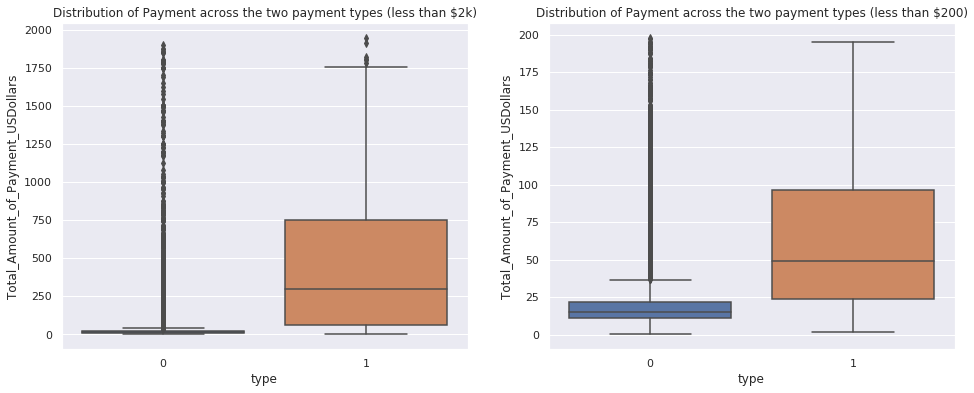

In [805]:
sns.set(rc={'figure.figsize':(16,6)})

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

r = res[res.Total_Amount_of_Payment_USDollars<2000]
ax = sns.boxplot(x="type", y="Total_Amount_of_Payment_USDollars", data=r, ax=ax1).set_title('Distribution of Payment across the two payment types (less than $2k)')

r = res[res.Total_Amount_of_Payment_USDollars<200]
ax = sns.boxplot(x="type", y="Total_Amount_of_Payment_USDollars", data=r, ax=ax2).set_title('Distribution of Payment across the two payment types (less than $200)')



It is clearly seen that the research payments tend to be a lot higher than the general payments - with not many overlaps. As such, it would be good to perhaps encode this to categorical in the **Feature Engineering** part.

Moving on to our next feature - **Form of Payment**

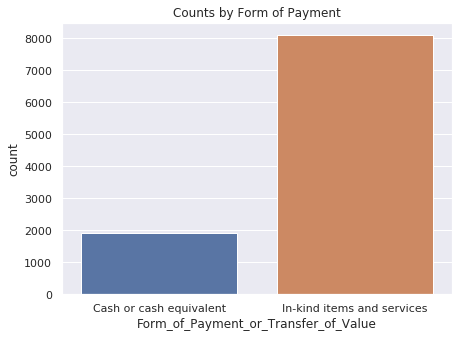

In [634]:
sns.set(rc={'figure.figsize':(7,5)})

ax = sns.countplot(x='Form_of_Payment_or_Transfer_of_Value', data=res).set_title("Counts by Form of Payment")

A bulk of our payments (around 80%) happen **in-kind**.

Text(0.5, 1.0, 'Form_of_Payment_or_Transfer_of_Value vs Proportion of Research Payments')

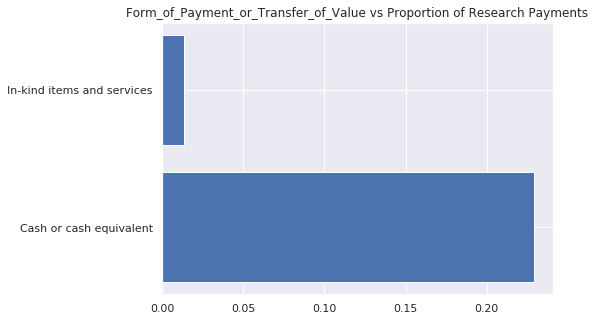

In [635]:
r = res.groupby('Form_of_Payment_or_Transfer_of_Value')['type'].agg(np.mean).reset_index()
plt.barh(r['Form_of_Payment_or_Transfer_of_Value'],r['type'])
plt.title('Form_of_Payment_or_Transfer_of_Value vs Proportion of Research Payments')

We find that the proportion of the **Cash payments** in **research transaction** are a lot higher than their **In-kind** counterpart. However we don't drop this by cosidering it to be a leaky feature because both categories have less than 25% of research transactions.

Moving on to some more features that have too many categories to handle - they will be handled in the Feature Engineering part (bottom coding). 

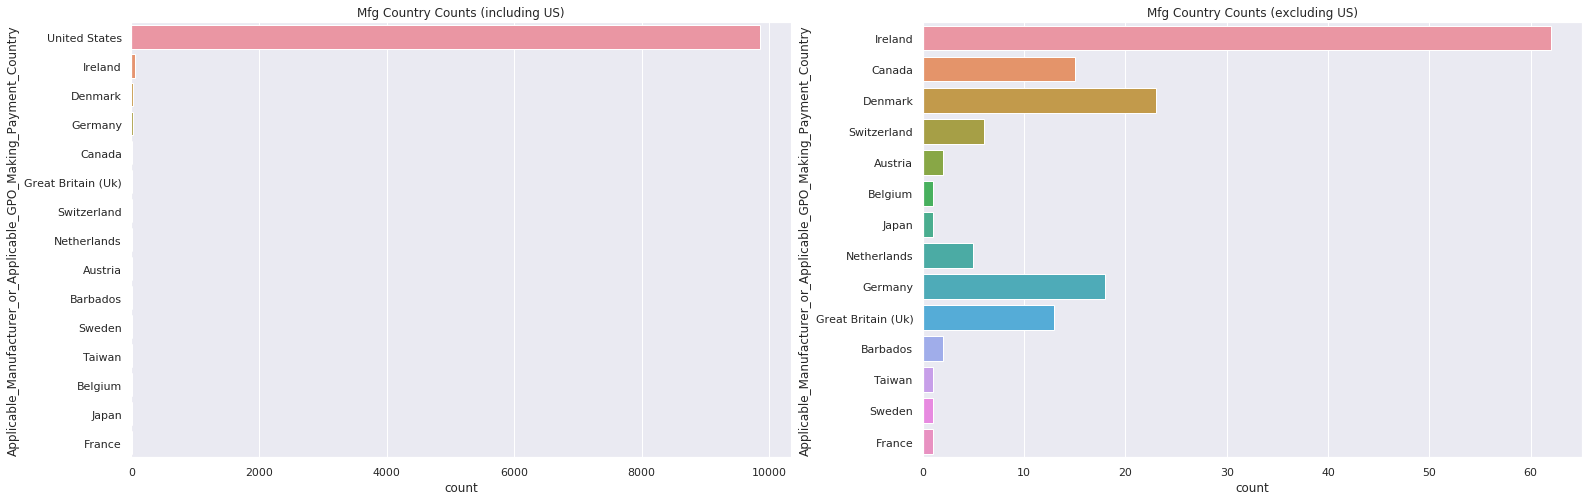

In [636]:
sns.set(rc={'figure.figsize':(26,8)})

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

ax = sns.countplot(y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', data=res,order = res['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'].value_counts().index,ax=ax1).set_title('Mfg Country Counts (including US)')

ax = sns.countplot(y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', data=res[res['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'] != "United States"],ax=ax2).set_title('Mfg Country Counts (excluding US)')


The top manufacturer countries with their counts are shown. A vast majority of manufacturers are US based (95% +), but distribution over the rest is also observed.

Text(0.5, 1.0, 'Proportion of Research payments by category')

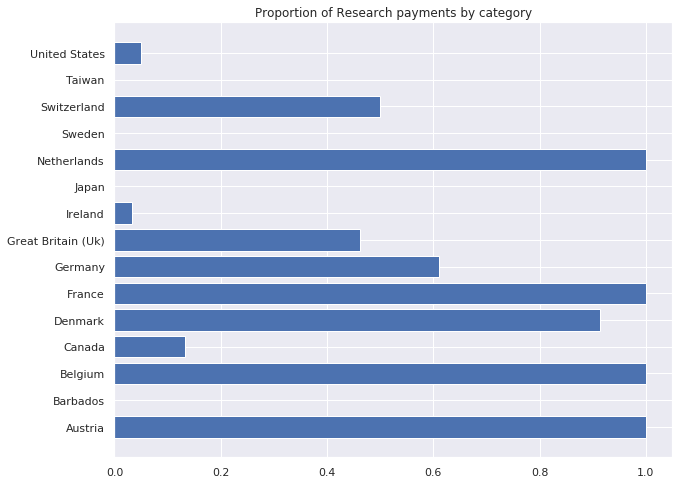

In [637]:
sns.set(rc={'figure.figsize':(10,8)})

r = res.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country')['type'].agg(np.mean).reset_index()
plt.barh(r['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'],r['type'])
plt.title('Proportion of Research payments by category')

Proportion of Research Payments for the various countries is observed. Countries with high counts (USA, Ireland, Canada) tend to have lower proportions of research payments.

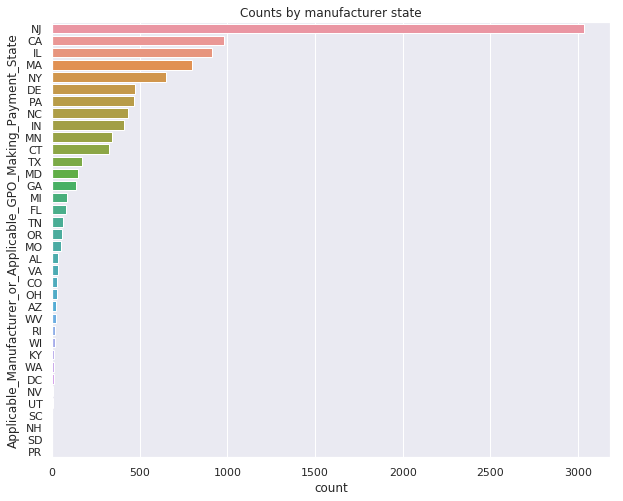

In [638]:

ax = sns.countplot(y='Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', data=res,order = res['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'].value_counts().index).set_title("Counts by manufacturer state")



Text(0.5, 1.0, 'Proportions of Research payments for different Mfg States')

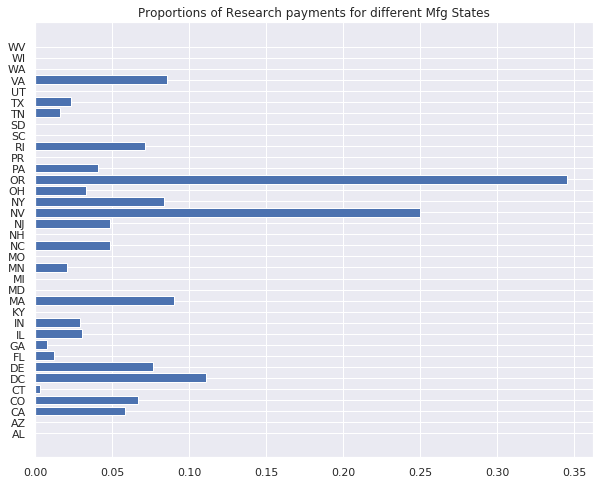

In [639]:
r = res.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State')['type'].agg(np.mean).reset_index()
plt.barh(r['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'],r['type'])
plt.title('Proportions of Research payments for different Mfg States')

The following are the proportions of Research payments for different states. OR and NV have a lot higher proportion of grants, but very low counts.

Most other columns have too many values, and will be excluded for our baseline model. Eventually we'll consider the top-5 categories and label the rest as a separate "other" category.

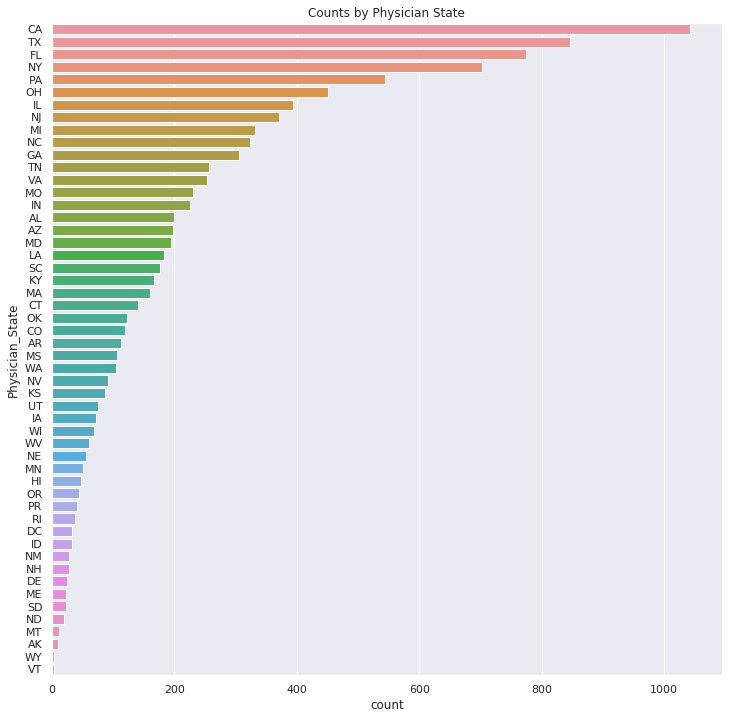

In [640]:
sns.set(rc={'figure.figsize':(12,12)})

ax = sns.countplot(y='Physician_State', data=res,order = res['Physician_State'].value_counts().index).set_title("Counts by Physician State")


Text(0.5, 1.0, 'Proportions of Research payments for different Physician States')

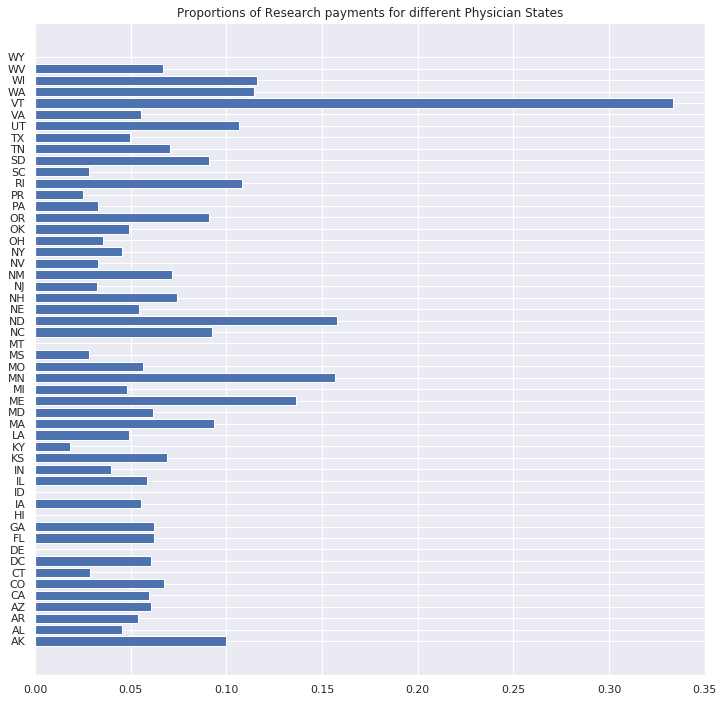

In [641]:
r = res.groupby('Physician_State')['type'].agg(np.mean).reset_index()
plt.barh(r['Physician_State'],r['type'])
plt.title('Proportions of Research payments for different Physician States')

Among the high count physician states, most have very low research payment proportions.


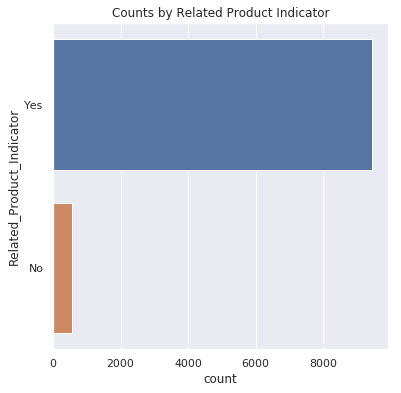

In [642]:
sns.set(rc={'figure.figsize':(6,6)})

ax = sns.countplot(y='Related_Product_Indicator', data=res,order = res['Related_Product_Indicator'].value_counts().index).set_title("Counts by Related Product Indicator")


Text(0.5, 1.0, 'Proportions of Research payments for different Related_Product_Indicator')

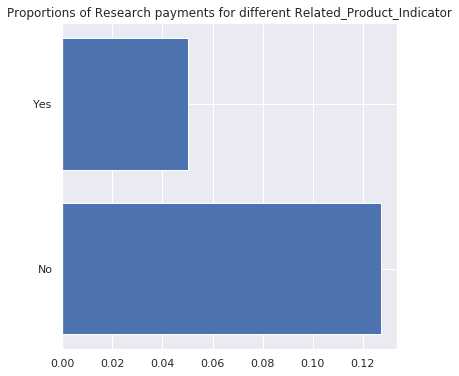

In [643]:
r = res.groupby('Related_Product_Indicator')['type'].agg(np.mean).reset_index()
plt.barh(r['Related_Product_Indicator'],r['type'])
plt.title('Proportions of Research payments for different Related_Product_Indicator')

We can see that very small proportion of both "Yes" and "No" categories tend to be Research payments, however No category has almost 3 times the percentage of research payments.

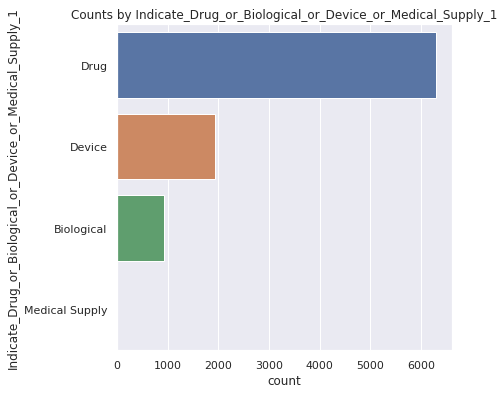

In [644]:
ax = sns.countplot(y='Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', data=res,order = res['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'].value_counts().index).set_title('Counts by Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1')


Text(0.5, 1.0, 'Proportions of Research payments for different Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1')

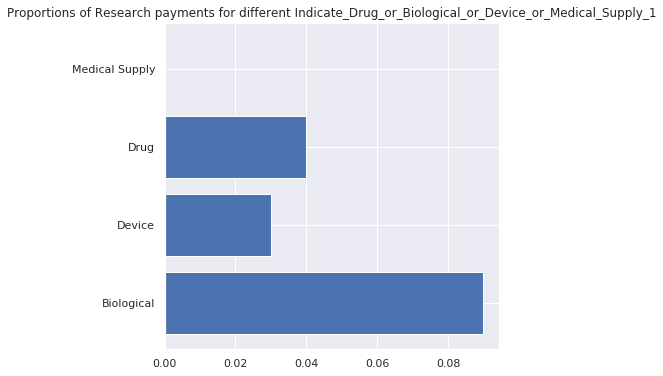

In [645]:
r = res.groupby('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1')['type'].agg(np.mean).reset_index()
plt.barh(r['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'],r['type'])
plt.title('Proportions of Research payments for different Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1')


Drug is by far the most common category, by counts, with however a very low research payment proportion. We can see that Biological category has a relatively higher research payment proportion.

## Task 2 : Pre-processing and Baseline Model

We will now be dropping quite a few columns for our baseline model, the reason being,
    
    
    -Very specific feature, like "name","id","zipcode"
    
    -Very high category count, this follows from the previous reason. We don't want resulting sparse columns after one-hot coding.
    
    - Have only one category perhaps because of subsetting, eg. 'Delay_in_Publication_Indicator', 'Dispute_Status_for_Publication',etc.

In [865]:
x = ['Physician_Country', 'Delay_in_Publication_Indicator', 'Dispute_Status_for_Publication', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Payment_Publication_Date','Date_of_Payment','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Physician_First_Name','Physician_Last_Name','Physician_Middle_Name','Physician_Primary_Business_Street_Address_Line1','Physician_Profile_ID','Physician_Zip_Code','Record_ID','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name','Physician_City','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State','Physician_License_State_code1','Physician_Specialty','Physician_State','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name','Program_Year','Covered_Physician_Type']
res.drop(x, axis=1, inplace=True)

Features like 'Physician_Country', 'Delay_in_Publication_Indicator',etc have been dropped for the baseline model. We'll use them once we have engineered them to reduce categories.


Following are the remaining columns we'll consider for our baseline model :

In [866]:
set(list(res))-set(['type'])

{'Change_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_Primary_Type',
 'Product_Category_or_Therapeutic_Area_1',
 'Related_Product_Indicator',
 'Total_Amount_of_Payment_USDollars'}

In [867]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score

We now break down the dataset into **train**,**val** and **test**. 

Running the logistic regression, we also handle the preprocessing tasks within the Pipeline, i.e Categorical variables are one-hot-encoded and imputed with 'missing' - whereas continuous values are scaled via **StandardScaler()** and imputed via **SimpleImputer()**.

In [868]:
X = res.drop('type', axis=1)
y = res['type']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

In [870]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include='object').columns.tolist()
#categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])


scores = cross_val_score(clf, X_train, y_train, cv=10,scoring='f1_weighted')

print("Average Precision Training score using Logistic Regression: "+str(scores.mean()))


from sklearn.model_selection import cross_val_predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
# scores = cross_val_score(clf, X_test, y_test, cv=10,scoring='average_precision')

print("Average Precision Test score using Logistic Regression: "+str(scores.mean()))


Average Precision Training score using Logistic Regression: 0.9503487447447991
Average Precision Test score using Logistic Regression: 0.9363568715278328


We observe that Logistic regression gives us a very high training and test accuracy. The 93.63% test accuracy was achieved using just the baseline model.

**Grid Search CV - on the regularization parameter 'c'**

In [880]:
param_grid = {
    'classifier__C': np.logspace(-1, 4, 13),
}

grid = GridSearchCV(clf, param_grid, cv=4, iid=False,scoring ='f1_weighted' )
grid.fit(X_train, y_train)
print("Logistic regression:")
print("Best parameters: ")
print(grid.best_params_)
print("Best Average Precision Train score using Logistic Regression: "+str(grid.best_score_))
y_pred = grid.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
print("Best Average Precision Test score using Logistic Regression: "+str(scores))



Logistic regression:
Best parameters: 
{'classifier__C': 1467.7992676220706}
Best Average Precision Train score using Logistic Regression: 0.9523477659406364
Best Average Precision Test score using Logistic Regression: 0.9337780987555002


**Similar Result** :: Test Average Precision is more or less the same at 93.43% with GridSearch on the various possible values of 'c'.

In [883]:
# from sklearn import metrics
# proba = cross_val_predict(clf, X_train,y_train, cv=5, method='predict_proba')
# fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
# auc = metrics.roc_auc_score(y_test, proba[::,1])
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

The ROC curve constrcted has an area of 0.986. We hope to improve this with the future models.

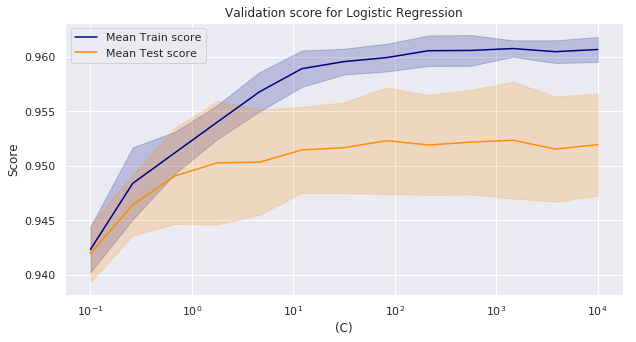

In [882]:
alphas = np.logspace(-1, 4, 13)

train_scores_mean = grid.cv_results_["mean_train_score"]
train_scores_std = grid.cv_results_["std_train_score"]
test_scores_mean = grid.cv_results_["mean_test_score"]
test_scores_std = grid.cv_results_["std_test_score"]

plt.figure()
plt.title('Validation score for Logistic Regression')
plt.xlabel('(C)')
plt.ylabel('Score')

plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
             color='navy')

plt.gca().fill_between(alphas,
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std,
                       alpha=0.2,
                       color='navy')
plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')


plt.gca().fill_between(alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

plt.legend(loc='best')
plt.show()

In [884]:
estimator=grid.best_estimator_.named_steps['classifier'].coef_[0].tolist()
category_B = preprocessor.fit(X_train).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A = X.select_dtypes(include='number').columns.tolist()
features_C= numerical_A+category_B
dictionary = dict(zip(features_C, estimator))
sorted_dictionary = sorted(dictionary, key=lambda dict_key: abs(dictionary[dict_key]), reverse=True)[:10]
sorted_dictionary_values=[]
for elem in sorted_dictionary:
    sorted_dictionary_values.append(dictionary[elem])

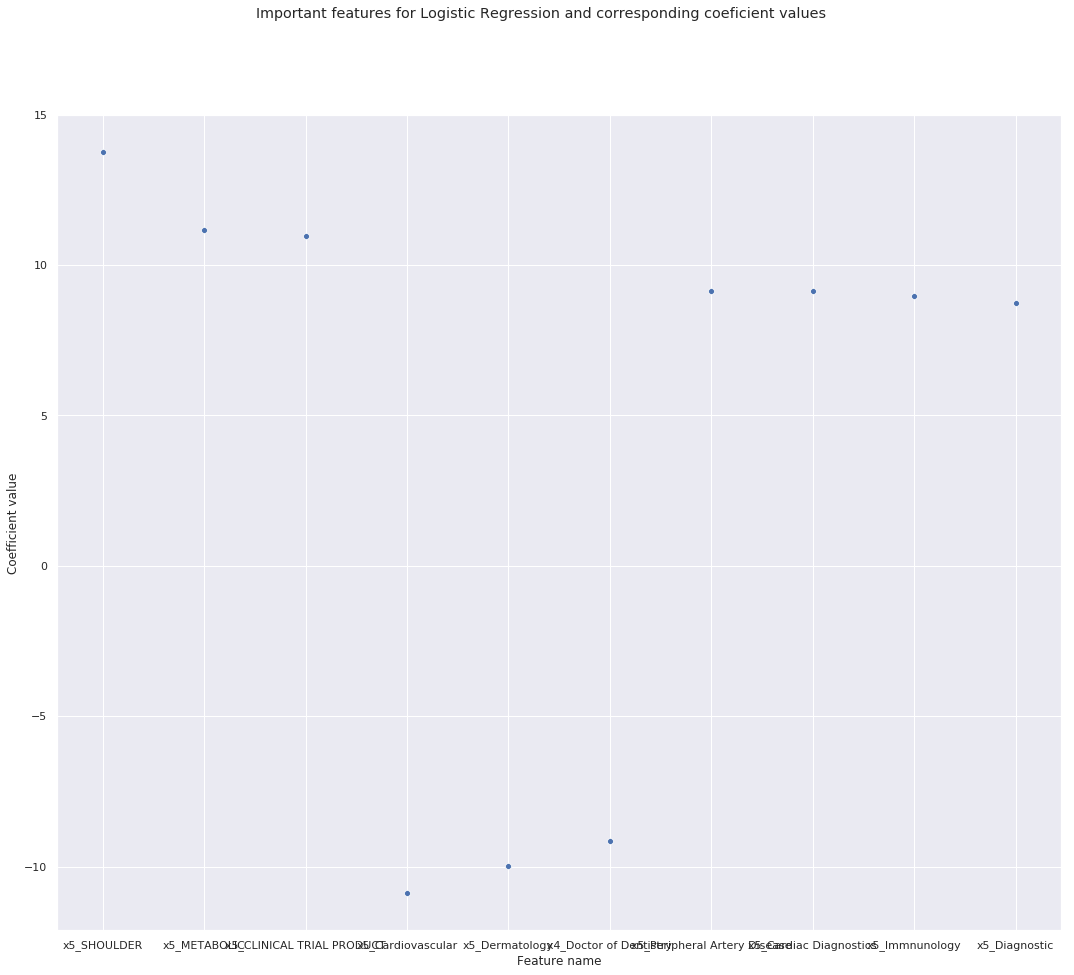

In [885]:
sns.set(rc={'figure.figsize':(18,15)})
sns.scatterplot(sorted_dictionary,sorted_dictionary_values)
plt.suptitle("Important features for Logistic Regression and corresponding coeficient values ")
plt.xlabel("Feature name")
plt.ylabel("Coefficient value")
plt.show()

We get our best coefficient values for the logistic regression model : the best performing features (aka highest magnitude of coefficient) are **Product_Category_or_Therapeutic_Area_1** and **Covered_Physician_Type**.

## Task 3 :: Feature Engineering

We will now engineer new features and reduce the categories in some of our categorical features.

The following code chunk finds the top5 categories by count for each categorical variable with high category count. All the other categories are set as a new category - "Other"

Some variables included in this transformation are : Manufacturer country, Drug name, Physician city, etc.

In [1373]:
res = result.sample(n=20000, random_state=1)

def convert(row):
    if isinstance(row, str):
        if row in top5:
            return row
        else:
            return "Other"
    else:
        return row
    
r = res.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country[:5].tolist()
res['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'] = res.apply(lambda row: convert(row['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State']),axis=1 ) 

r = res.groupby('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name[:5].tolist()
res['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name'] = res.apply(lambda row: convert(row['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name']),axis=1 ) 

r = res.groupby('Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1[:5].tolist()
res['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'] = res.apply(lambda row: convert(row['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1']),axis=1 ) 

r = res.groupby('Physician_City',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Physician_City[:5].tolist()
res['Physician_City'] = res.apply(lambda row: convert(row['Physician_City']),axis=1 ) 

r = res.groupby('Physician_Country',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Physician_Country[:5].tolist()
res['Physician_Country'] = res.apply(lambda row: convert(row['Physician_Country']),axis=1 ) 

r = res.groupby('Physician_State',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Physician_State[:5].tolist()
res['Physician_State'] = res.apply(lambda row: convert(row['Physician_State']),axis=1 ) 

r = res.groupby('Product_Category_or_Therapeutic_Area_1',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Product_Category_or_Therapeutic_Area_1[:5].tolist()
res['Product_Category_or_Therapeutic_Area_1'] = res.apply(lambda row: convert(row['Product_Category_or_Therapeutic_Area_1']),axis=1 )

r = res.groupby('Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name[:5].tolist()
res['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name'] = res.apply(lambda row: convert(row['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']),axis=1 )



We see that the **Physician specialty** is a list of specialties of the form :

In [1210]:
res.Physician_Specialty.head()

161179                                                    NaN
5763978     Allopathic & Osteopathic Physicians|Internal M...
3258205     Allopathic & Osteopathic Physicians|Internal M...
10572478    Allopathic & Osteopathic Physicians|Internal M...
9295908     Allopathic & Osteopathic Physicians|Psychiatry...
Name: Physician_Specialty, dtype: object

This can obviously take a lot of values - however it was observed that specialties occuring anywhere as the first specialty would never occur in between. It would be a good idea to create a column only with these values. 

This is what the column looks like now :

In [1374]:
res.Physician_Specialty = res.Physician_Specialty.str.split('|')
res.Physician_Specialty = res.Physician_Specialty.str[0]
res.Physician_Specialty.head()

161179                                      NaN
5763978     Allopathic & Osteopathic Physicians
3258205     Allopathic & Osteopathic Physicians
10572478    Allopathic & Osteopathic Physicians
9295908     Allopathic & Osteopathic Physicians
Name: Physician_Specialty, dtype: object

This still contains a lot of categories, so we'll remove combine the low frequency categories into one :

In [1212]:
res.Physician_Specialty.unique()

array([nan, 'Allopathic & Osteopathic Physicians',
       'Eye and Vision Services Providers', 'Other Service Providers',
       'Dental Providers',
       'Podiatric Medicine & Surgery Service Providers',
       'Student, Health Care',
       'Behavioral Health & Social Service Providers', 'Hospitals',
       'Chiropractic Providers', 'Ambulatory Health Care Facilities',
       'Group'], dtype=object)

In [1375]:
r = res.groupby('Physician_Specialty',as_index=False)['type'].count().sort_values('type', ascending=False)
top5 = r.Physician_Specialty[:5].tolist()
res['Physician_Specialty'] = res.apply(lambda row: convert(row['Physician_Specialty']),axis=1 )


Text(0.5, 1.0, 'Physician_Specialty vs Proportion of General Payment counts')

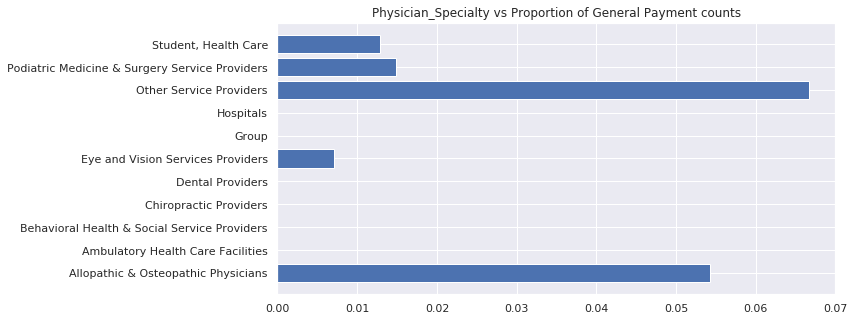

In [1213]:
sns.set(rc={'figure.figsize':(10,5)})
r = res.groupby('Physician_Specialty')['type'].agg(np.mean).reset_index()
plt.barh(r['Physician_Specialty'],r['type'])
plt.title('Physician_Specialty vs Proportion of General Payment counts')


We can convert the **Payment** to discrete categories ; since we have observed that almost all payments are below 200 - it would be better to categorize our our payments into 
        - less than $20 , mostly for General Payments
    - between $20 and $40, both General and Research
    - between $40 and $80, mostly Research
    - greater than $80 and less than $500, almost always Research
    - greater than $500

In [1376]:
def convert(row):
    if row <= 20:
        return "one"
    elif row<=40:
        return "two"
    elif row<=80:
        return "three"
    elif row<=500:
        return "four"
    else:
        return "five"
res['Total_Amount_of_Payment_USDollars_new'] = res.apply(lambda row: convert(row['Total_Amount_of_Payment_USDollars']),axis=1)


We have engineered quite a few features, we'll now drop the rest.

In [1377]:
x = [ "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID",'Delay_in_Publication_Indicator', 'Dispute_Status_for_Publication', 'Payment_Publication_Date','Date_of_Payment','Physician_First_Name','Physician_Last_Name','Physician_Middle_Name','Physician_Primary_Business_Street_Address_Line1','Physician_Profile_ID','Physician_Zip_Code','Record_ID','Physician_License_State_code1','Program_Year','Covered_Physician_Type']
X = res.drop('type', axis=1)
X = X.drop(x,axis=1)
y = res['type']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)



### SMOTE to handle Feature Imbalance

In [1378]:
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(random_state=12, categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

numeric_features = X_train.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = X_train.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_imp= pd.DataFrame(clf.fit_transform(X_train))




In [1379]:
x_train_res, y_train_res = sm.fit_sample(X_train_imp, y_train)
x_train_res2 = pd.DataFrame(x_train_res)
y_train_res2 = pd.DataFrame(y_train_res)
x_train_res2.columns= ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Change_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_City',
 'Physician_Country',
 'Physician_Primary_Type',
 'Physician_Specialty',
 'Physician_State',
 'Product_Category_or_Therapeutic_Area_1',
 'Related_Product_Indicator',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Total_Amount_of_Payment_USDollars_new']

In [1380]:
x_train_res2.Total_Amount_of_Payment_USDollars=pd.to_numeric(x_train_res2.Total_Amount_of_Payment_USDollars)


We will now run a logistic regression as before, with the data fitted to SMOTE.

In [1268]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

scores = cross_val_score(clf, x_train_res2, y_train_res2, cv=10,scoring='f1_weighted')

print("Average Precision Training score using Logistic Regression: "+str(scores.mean()))


from sklearn.model_selection import cross_val_predict
clf.fit(x_train_res2, y_train_res2)
y_pred = clf.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted', pos_label=0)

print("Average Precision Test score using Logistic Regression: "+str(scores.mean()))


Average Precision Training score using Logistic Regression: 0.9445670090365098
Average Precision Test score using Logistic Regression: 0.9254172201449651


**Improvement** : The training score goes up to 0.944, and test up to 0.925

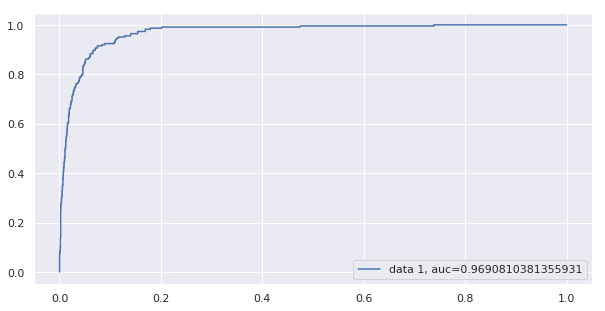

In [1383]:
sns.set(rc={'figure.figsize':(10,5)})

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

proba = cross_val_predict(clf, X_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The following ROC curve gives us the AUC metric at 0.96

## Task 4 : Any Model

**Tree Based Models**

This process has been broken down into steps :

i). Feature Engineering in the Context of Tree Based Algorithms (reduce categories).

ii). Just a normal decision tree classifier, with controlled depth.

iii). Grid Search CV to find the best parameters for given depth.

iv). **Ensemble** Random Forest classifier built with best parameters. Determine best features (gives robust features).

v). **Ensemble** Gradient Boosting classifiers built with best parameters. Determine best features (gives robust features).

**Feature Engineering in the context of Decision Trees means lesser features. This was taken up in the previous section, where columns where we've taken top-5 features and an extra "other" feature.**



We run a simple **Decision tree classifier**, and limited the depth to 7 so as to not overfit.

In [1293]:
from sklearn.tree import DecisionTreeClassifier

numeric_features = X.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=7))])

scores = cross_val_score(clf, x_train_res2, y_train_res2,scoring='f1_weighted')
print("Mean Cross validation score using Decision Tree Classifier: "+str(scores.mean()))

from sklearn.model_selection import cross_val_predict
clf.fit(x_train_res2, y_train_res2)
y_pred = clf.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
# scores = cross_val_score(clf, X_test, y_test, cv=10,scoring='average_precision')

print("Average Precision Test score using simple Decision Tree: "+str(scores.mean()))


Mean Cross validation score using Decision Tree Classifier: 0.9445085494575798
Average Precision Test score using simple Decision Tree: 0.9269224884349802


A train score of 0.944 (f1 weighted) was obtained, and the test score is a close 0.9269.

We'll now try grid optimization to improve our score. Max features is the parameter being supplied.

In [1302]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=7))])

param_grid = {
 'classifier__max_features': ['auto', 'sqrt']}

grid_decision = GridSearchCV(clf, param_grid, cv=3, iid=False)
grid_decision.fit(x_train_res2, y_train_res2)
print("Decision Tree Classifier:")
print("Best parameters: ")
print(grid_decision.best_params_)
print("Best score: ")
print(grid_decision.best_score_)

y_pred = grid_decision.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
print("Best Average Precision Test score using Grid CV for Decision tree: "+str(scores))


Decision Tree Classifier:
Best parameters: 
{'classifier__max_features': 'sqrt'}
Best score: 
0.9167080231596362
Best Average Precision Test score using Grid CV for Decision tree: 0.9230853028223869


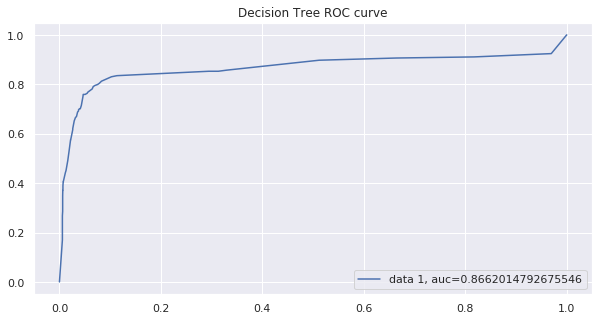

In [1400]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=7))])
clf.fit(x_train_res2, y_train_res2)

proba = cross_val_predict(clf, X_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Decision Tree ROC curve')
plt.show()

It returns **sqrt** as the optimal value of the max features hyperparameter, which will be incorporated in further analyses including the ensemble model.

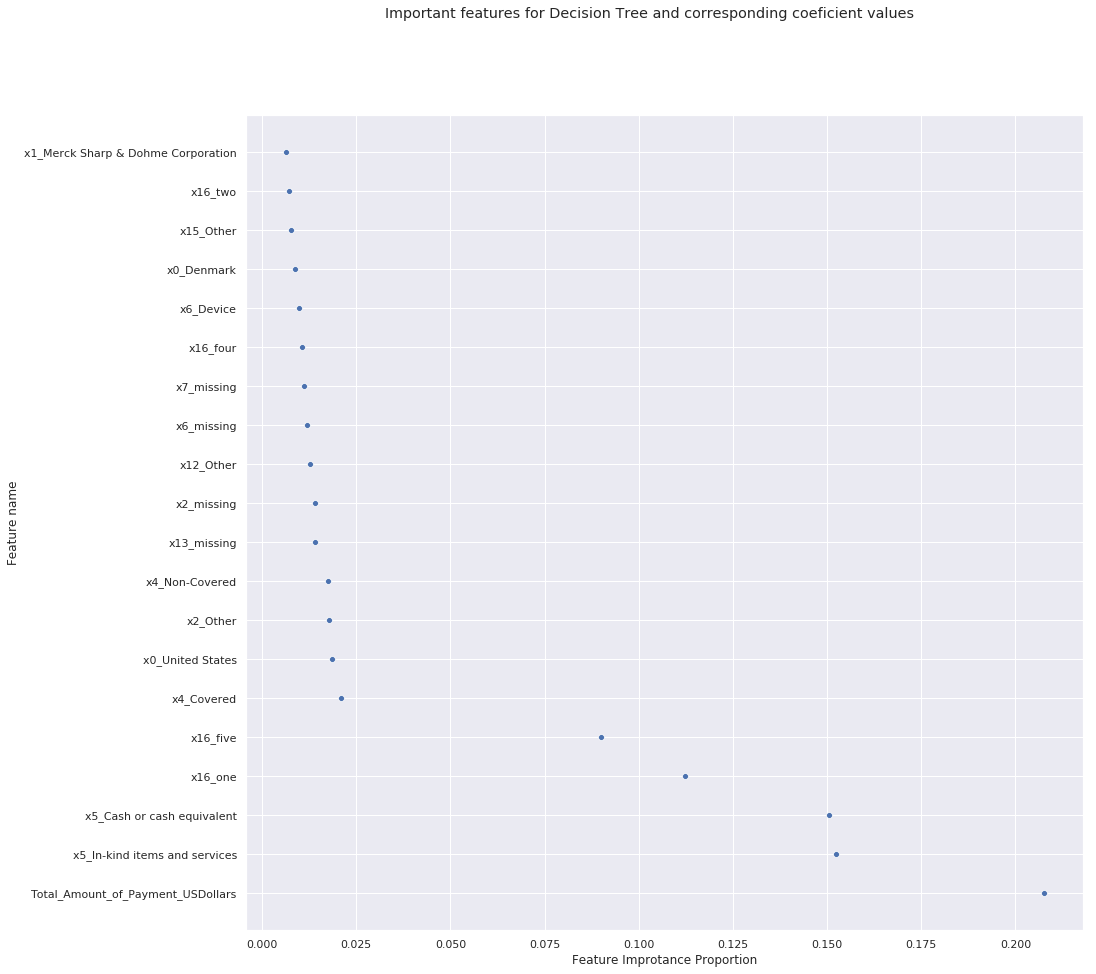

In [1314]:
estimator = grid_decision.best_estimator_.named_steps['classifier'].feature_importances_.tolist()
category_B = preprocessor.fit(x_train_res2).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A = X.select_dtypes(include='number').columns.tolist()
features_C= numerical_A+category_B
dictionary = dict(zip(features_C, estimator))
sorted_dictionary = sorted(dictionary, key=lambda dict_key: abs(dictionary[dict_key]), reverse=True)[:20]
sorted_dictionary_values=[]
for elem in sorted_dictionary:
    sorted_dictionary_values.append(dictionary[elem])
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(sorted_dictionary_values,sorted_dictionary)
plt.suptitle("Important features for Decision Tree and corresponding coeficient values ")
plt.ylabel("Feature name")
plt.xlabel("Feature Improtance Proportion")
plt.show()

**Chart above is a list of the most important features, however it would be better to select our features from an ensemble model since that would be more robust.**

Now follows a random forest model with the optimized parameters.

In [1392]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators = 200,max_features='auto',max_depth=7))])

scores = cross_val_score(clf, x_train_res2, y_train_res2,scoring='f1_weighted')
print("Mean Cross validation score using Random Forest ensemble (200 trees) Classifier: "+str(scores.mean()))

from sklearn.model_selection import cross_val_predict
clf.fit(x_train_res2, y_train_res2)
y_pred = clf.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
# scores = cross_val_score(clf, X_test, y_test, cv=10,scoring='average_precision')

print("Average Precision Test score using Random Forest: "+str(scores.mean()))


Mean Cross validation score using Random Forest ensemble (200 trees) Classifier: 0.9408482698789494
Average Precision Test score using Random Forest: 0.9148939291937271


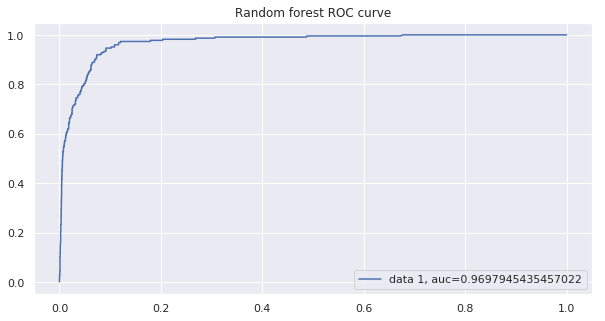

In [1399]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators = 200,max_features='auto',max_depth=7))])
clf.fit(x_train_res2, y_train_res2)
proba = cross_val_predict(clf, X_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('Random forest ROC curve')
plt.legend(loc=4)
plt.show()

The AUC metric shows a considerable increase in Random Forest, which is a good thing.

A random forest with 200 trees was constructed, we observe an 0.94 f1-weighted on training set and 0.915 on the test. We'll now try grid search to get better results.

In [1313]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=7))])

param_grid = {'classifier__n_estimators':range(100,400,100),'classifier__max_features':['sqrt','auto']}

grid_decision = GridSearchCV(clf, param_grid, cv=3, iid=False)
grid_decision.fit(x_train_res2, y_train_res2)
print("Decision Tree Classifier:")
print("Best parameters: ")
print(grid_decision.best_params_)
print("Best score: ")
print(grid_decision.best_score_)
grid_decision.fit(x_train_res2,y_train_res2)
y_pred = grid_decision.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
print("Best Average Precision Test score using Logistic Regression: "+str(scores))

Decision Tree Classifier:
Best parameters: 
{'classifier__max_features': 'sqrt', 'classifier__n_estimators': 300}
Best score: 
0.9447477253928867
Best Average Precision Test score using Logistic Regression: 0.9233587922162944


**Improvement** A marginal improvement in our f1-training 0.944 was observed.

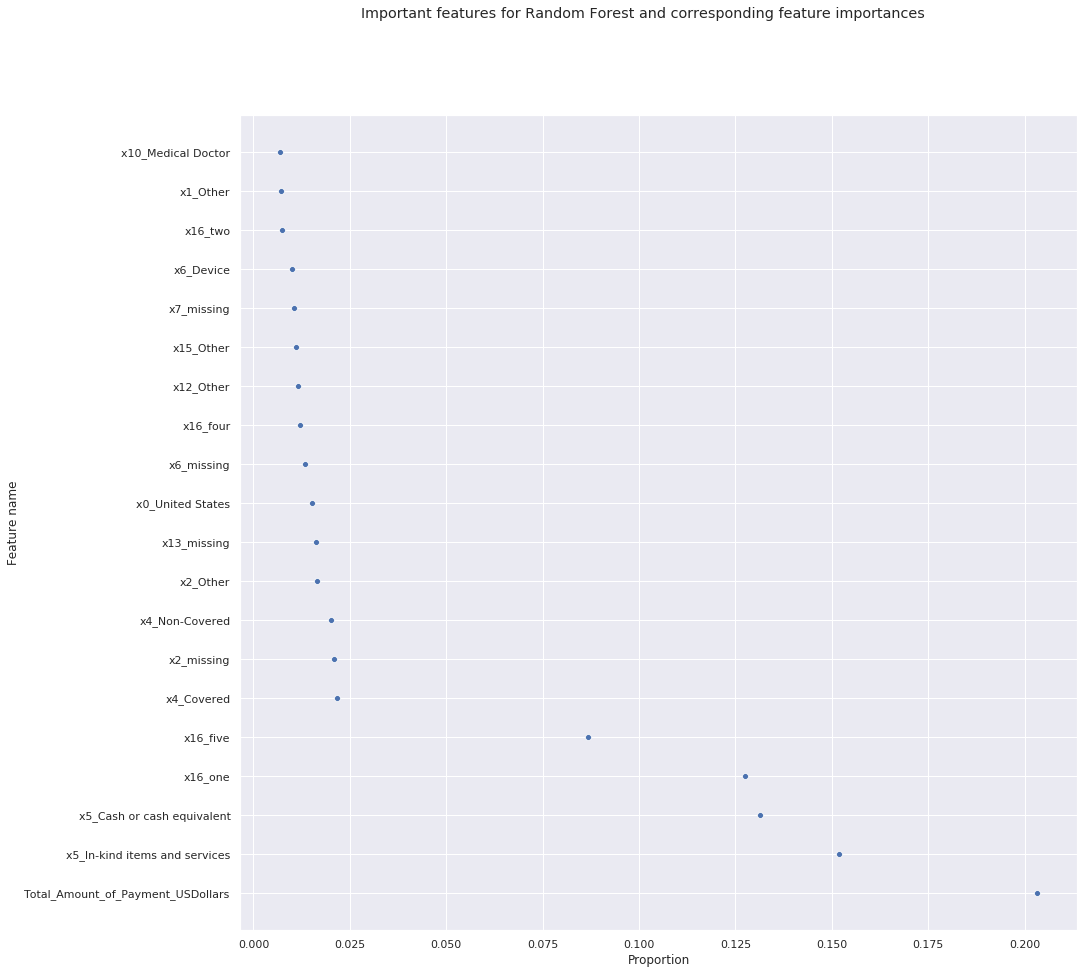

In [1279]:
estimator = grid_decision.best_estimator_.named_steps['classifier'].feature_importances_.tolist()
category_B = preprocessor.fit(x_train_res2).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A = X.select_dtypes(include='number').columns.tolist()
features_C= numerical_A+category_B
dictionary = dict(zip(features_C, estimator))
sorted_dictionary = sorted(dictionary, key=lambda dict_key: abs(dictionary[dict_key]), reverse=True)[:20]
sorted_dictionary_values=[]
for elem in sorted_dictionary:
    sorted_dictionary_values.append(dictionary[elem])
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(sorted_dictionary_values,sorted_dictionary)
plt.suptitle("Important features for Random Forest and corresponding feature importances ")
plt.ylabel("Feature name")
plt.xlabel("Proportion")
plt.show()

Following are the top 6 most important features based on our Ensemble tree based model:

- Total_Amount_of_Payment_USDollars, 
- Form_of_Payment_or_Transfer_of_Value (cash or in-kind), 
- Total_Amount_of_Payment_USDollars ("one","five"), 
- Covered_or_Noncovered_Indicator_1 (non-covered),
- Product_Category_or_Therapeutic_Area_1(missing), 
- Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State(other)

Moving on to the next classifier, the Gradient Boosting Classifer's performance is tested.

In [1315]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(max_features='sqrt',max_depth=7))])
scores = cross_val_score(clf, x_train_res2, y_train_res2,scoring='f1_weighted')
print("Mean Cross validation score using Gradient Boosting Classifier: "+str(scores.mean()))

from sklearn.model_selection import cross_val_predict
clf.fit(x_train_res2, y_train_res2)
y_pred = clf.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
# scores = cross_val_score(clf, X_test, y_test, cv=10,scoring='average_precision')

print("Average Precision Test score using Gradient Boosting: "+str(scores.mean()))



Mean Cross validation score using Gradient Boosting Classifier: 0.9657856980966547
Average Precision Test score using Gradient Boosting: 0.9285300114245539


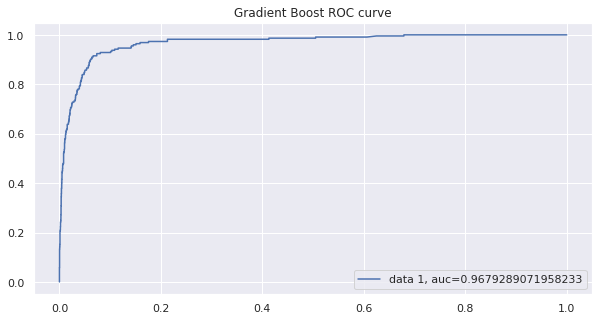

In [1398]:
clfa = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(max_features='sqrt',max_depth=7))])
clfa.fit(x_train_res2, y_train_res2)
proba = cross_val_predict(clfa, X_test,y_test, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  proba[::,1])
auc = metrics.roc_auc_score(y_test, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Gradient Boost ROC curve')
plt.show()

AUC marginally lesser than the Random Forest algo, but still quite high.

**Major Improvement** Gradient Boost gives us the best Training f1 score yet - 0.965. Avg precision Test scores are also the best so far.

Performing a grid search on the parameters **max depth** and **number of estimators** :

In [1316]:
param_grid = {
    'classifier__max_depth': [4,5,6,7],
    'classifier__n_estimators': [100,200,300],
}

grid_boosting = RandomizedSearchCV(clf, param_grid, cv=3, iid=False)
grid_boosting.fit(X_train, y_train)
print("Gradient Boosting Classifier:")
print("Best parameters: ")
print(grid_boosting.best_params_)
print("Best score: ")
print(grid_boosting.best_score_)

grid_boosting.fit(x_train_res2,y_train_res2)
y_pred = grid_boosting.predict(X_test)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)
print("Best Average Precision Test score using Gradient Boosting: "+str(scores))


Gradient Boosting Classifier:
Best parameters: 
{'classifier__n_estimators': 300, 'classifier__max_depth': 5}
Best score: 
0.9645311091751688
Best Average Precision Test score using Gradient Boosting: 0.9306084764941424


**Improvement** Train f1 scores are more or less the same, the test precision goes up to 0.93.

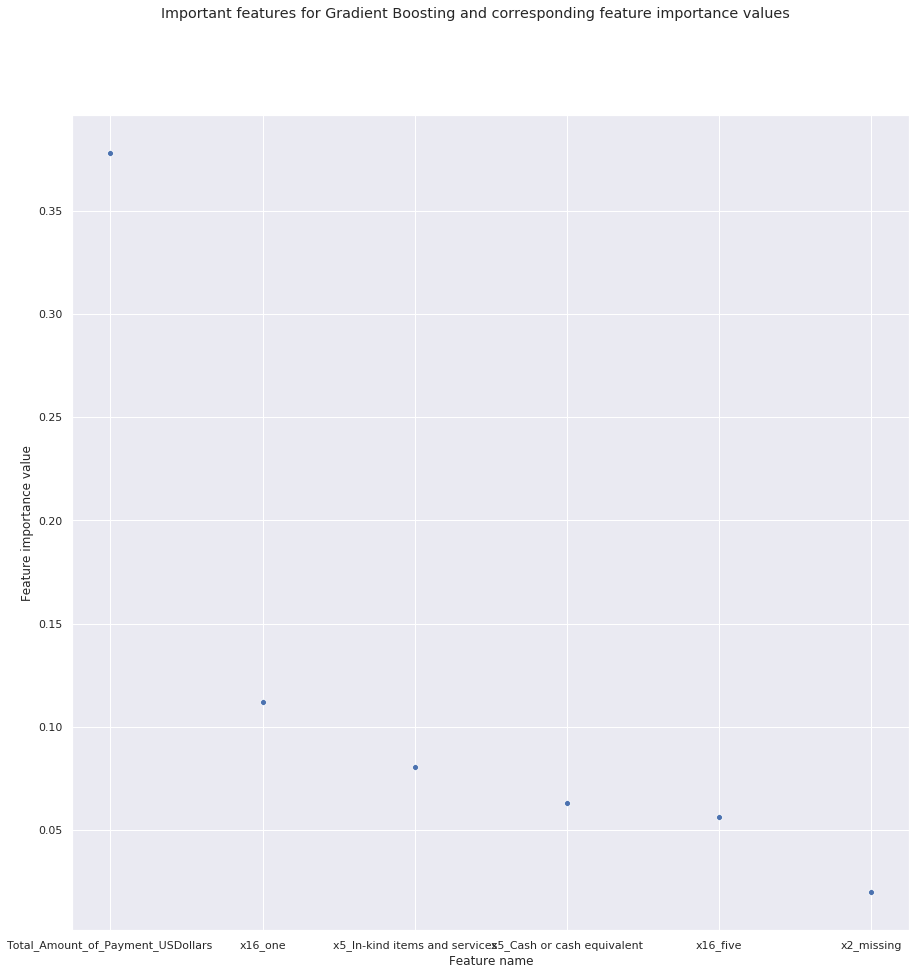

In [1286]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(max_depth=grid_boosting.best_params_['classifier__max_depth'],n_estimators=grid_boosting.best_params_['classifier__n_estimators']))])
estimator = grid_boosting.best_estimator_.named_steps['classifier'].feature_importances_
category_B = preprocessor.fit(X_train).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A = X.select_dtypes(include='number').columns.tolist()
features_C= numerical_A+category_B
dictionary = dict(zip(features_C, estimator))
sorted_dictionary = sorted(dictionary, key=lambda dict_key: abs(dictionary[dict_key]), reverse=True)[:6]
sorted_dictionary_values=[]
for elem in sorted_dictionary:
    sorted_dictionary_values.append(dictionary[elem])
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(sorted_dictionary,sorted_dictionary_values)
plt.suptitle("Important features for Gradient Boosting and corresponding feature importance values ")
plt.xlabel("Feature name")
plt.ylabel("Feature importance value")
plt.show()

Following are the top 6 most important features based on our Gradient Boost tree based model:

- Total_Amount_of_Payment_USDollars, 
- Form_of_Payment_or_Transfer_of_Value (cash or in-kind), 
- Total_Amount_of_Payment_USDollars (one,five),
- Product_Category_or_Therapeutic_Area_1(missing)

Moving on to our next algorithm - **Catboost**

In [1288]:
categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.05,
                           depth=7)
model.fit(x_train_res2,y_train_res2,categorical_features)


0:	learn: 0.5991077	total: 92.7ms	remaining: 9.18s
1:	learn: 0.5262650	total: 164ms	remaining: 8.01s
2:	learn: 0.4758968	total: 232ms	remaining: 7.5s
3:	learn: 0.4279080	total: 323ms	remaining: 7.76s
4:	learn: 0.3893134	total: 456ms	remaining: 8.66s
5:	learn: 0.3561786	total: 541ms	remaining: 8.48s
6:	learn: 0.3297174	total: 647ms	remaining: 8.6s
7:	learn: 0.3095808	total: 735ms	remaining: 8.45s
8:	learn: 0.2918546	total: 859ms	remaining: 8.68s
9:	learn: 0.2787113	total: 970ms	remaining: 8.73s
10:	learn: 0.2644869	total: 1.05s	remaining: 8.5s
11:	learn: 0.2528192	total: 1.17s	remaining: 8.57s
12:	learn: 0.2446040	total: 1.25s	remaining: 8.38s
13:	learn: 0.2363739	total: 1.33s	remaining: 8.18s
14:	learn: 0.2292508	total: 1.45s	remaining: 8.22s
15:	learn: 0.2232186	total: 1.53s	remaining: 8.04s
16:	learn: 0.2175228	total: 1.61s	remaining: 7.89s
17:	learn: 0.2120295	total: 1.74s	remaining: 7.92s
18:	learn: 0.2069542	total: 1.83s	remaining: 7.79s
19:	learn: 0.2024101	total: 2.02s	remaining

In [1318]:
numeric_features = x_train_res2.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = x_train_res2.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor)])
X_test2= pd.DataFrame(clf.fit_transform(X_val))
X_test2.columns= [
    'Total_Amount_of_Payment_USDollars',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Change_Type',
 'Covered_or_Noncovered_Indicator_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Physician_City',
 'Physician_Country',
 'Physician_Primary_Type',
 'Physician_Specialty',
 'Physician_State',
 'Product_Category_or_Therapeutic_Area_1',
 'Related_Product_Indicator',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Total_Amount_of_Payment_USDollars_new'
 ]
y_pred = model.predict(X_test2[x_train_res2.columns])
scores = average_precision_score(y_val, y_pred, average='weighted',pos_label=0)
# scores = cross_val_score(clf, X_test, y_test, cv=10,scoring='average_precision')

print("Average Precision Test score using Gradient Boosting: "+str(scores.mean()))


Average Precision Test score using Gradient Boosting: 0.9288736194760562


A decent test average precision, but not as good as the Gradient Boosting. No need to bother with further analysis of Catboost.

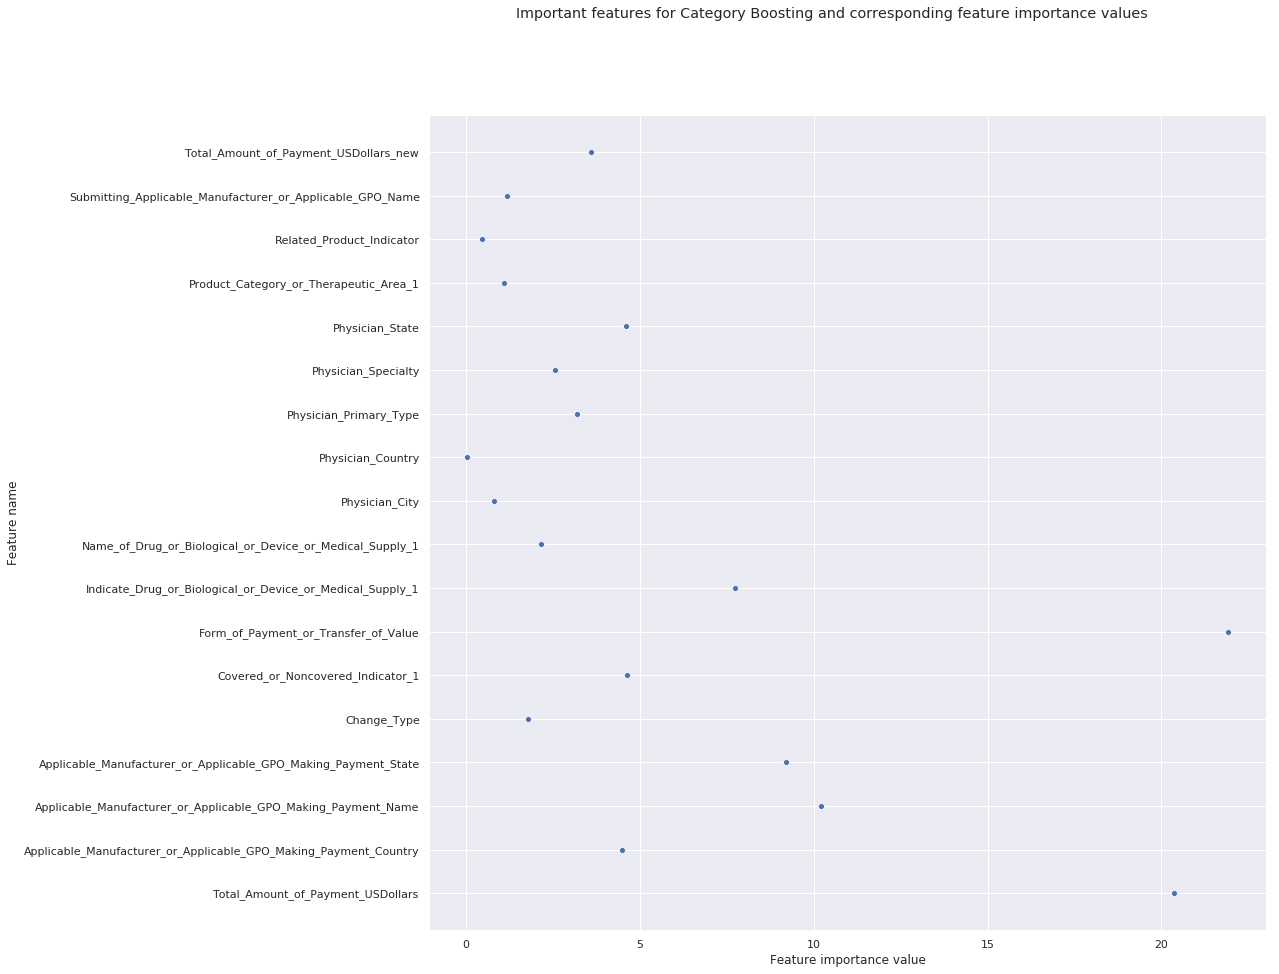

In [1292]:
categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
feature_imp = model.get_feature_importance(Pool(x_train_res2, label=y_train_res2, cat_features=categorical_features))
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(feature_imp,x_train_res2.columns)
plt.suptitle("Important features for Category Boosting and corresponding feature importance values ")
plt.ylabel("Feature name")
plt.xlabel("Feature importance value")
plt.show()

The important features seem to be:
- Form_of_Payment
- Payment in dollars
- Manufacturer Name
- Manufacturer State
- Drug or Biological Supply Indicator

In this analysis, the Gradient Boosting algorithm outperformed the rest. The training f1 score obtained was 0.965 and test average precision was 0.93.

## Task 5 :: Feature Selection

We dedicate this section to determining the most important features - using the **Mutual Info Statistic** - a univariate statistic which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.



In [1321]:
from sklearn.feature_selection import mutual_info_classif

### i). Preprocessing the balanced dataset  - continuous features are imputed and scaled, and the categorical features are imputed and one-hot-encoded.

In [1322]:
numeric_features = x_train_res2.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = x_train_res2.select_dtypes(include='object').columns.tolist()


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor)
                      ])
X_train_label=pd.DataFrame(clf.fit_transform(x_train_res2,y_train_res2))




In [1323]:
numeric_features = X_test.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X_test.select_dtypes(include='object').columns.tolist()


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf2 = Pipeline(steps=[('preprocessor', preprocessor2)
                      ])

X_test_label=pd.DataFrame(clf2.fit_transform(X_test,y_test))

### ii). Mutual Info scores are calculated for each of the preprocessed features to estimate dependency. 

In [1324]:
scores = mutual_info_classif(X_train_label, y_train_res2,
                                discrete_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])


### iii). Feature list is created, sorted on the basis of mutual info score and the top 5 features plotted

In [1325]:
category_B = preprocessor.fit(x_train_res2).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A = x_train_res2.select_dtypes(include='number').columns.tolist()
features_C= numerical_A+category_B
dictionary = dict(zip(features_C, scores))
sorted_dictionary = sorted(dictionary, key=lambda dict_key: abs(dictionary[dict_key]), reverse=True)[:7]
sorted_dictionary_values=[]
for elem in sorted_dictionary:
    sorted_dictionary_values.append(dictionary[elem])

In [1326]:
category_B2 = preprocessor2.fit(X_test).named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_A2 = X_test.select_dtypes(include='number').columns.tolist()
features_C2= numerical_A2+category_B2


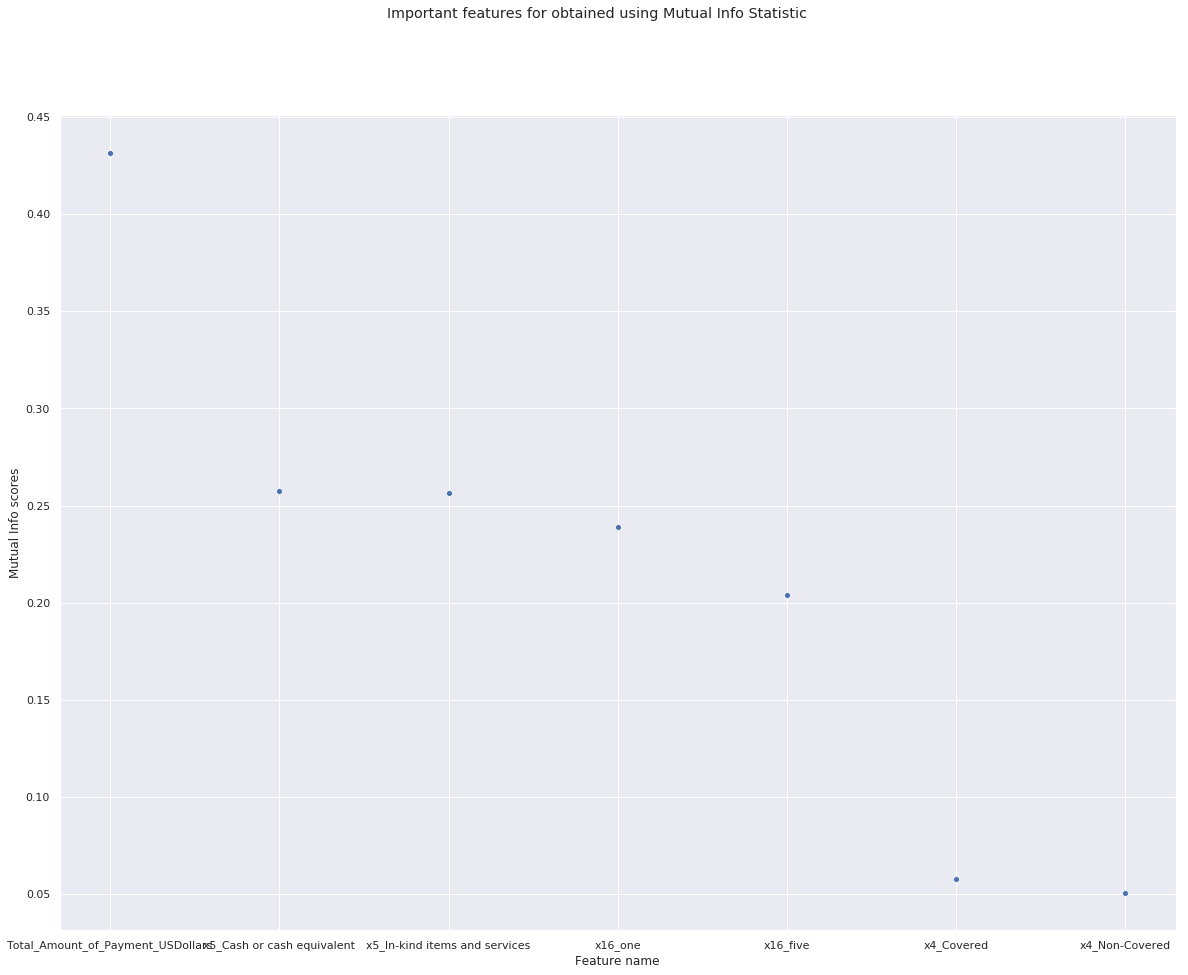

In [1327]:
sns.set(rc={'figure.figsize':(20,15)})
sns.scatterplot(sorted_dictionary,sorted_dictionary_values)
plt.suptitle("Important features for obtained using Mutual Info Statistic ")
plt.xlabel("Feature name")
plt.ylabel("Mutual Info scores")
plt.show()

The most important features were determined to be :
- Total Payment (strongest)
- Form_of_Payment_or_Transfer_of_Value (both categories)
- Total_Amount_of_Payment_USDollars_new (one,five)
- Product_Category_or_Therapeutic_Area_1


Now let us take this feature subset and estimate the performance on our best performing model : **Gradient Boosting Classifier**

In [1341]:
X_train_label.columns = features_C
X_train_label2 = X_train_label[sorted_dictionary]
X_test_label.columns = features_C2
X_test_label2 = X_test_label[sorted_dictionary]

In [1342]:
X_train_label.columns = features_C
X_train_label2 = X_train_label[sorted_dictionary]
X_test_label.columns = features_C2
X_test_label2 = X_test_label[sorted_dictionary]

clf = Pipeline(steps=[
                      ('classifier', GradientBoostingClassifier(max_features='sqrt',max_depth=7))])


clf.fit(X_train_label2, y_train_res2)
y_pred = clf.predict(X_test_label2)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)

print("Average Precision Test score using Gradient Boosting Classifier: "+str(scores.mean()))

Average Precision Test score using Gradient Boosting Classifier: 0.9469880472988621


**Improvement** : Avg precision test score goes up from 0.928 to 0.947. 

It is therefore noted that the model perfomance with the selected top feature subsample improves considerably.

## Task 6 :: An Explainable Model

We choose a simple decision tree classifier to make our final simple explainable model. Once we estimate the performance metric, we'll visualize the tree to get a better understanding of the working of our model.

In [1355]:
clf = Pipeline(steps=[
                      ('classifier', DecisionTreeClassifier(max_depth=4))])



scores = cross_val_score(clf, X_train_label2, y_train_res2,scoring='f1_weighted')


print("Mean Cross validation score using Decision tree classifier: "+str(scores.mean()))

clf.fit(X_train_label2, y_train_res2)
y_pred = clf.predict(X_test_label2)
scores = average_precision_score(y_test, y_pred, average='weighted',pos_label=0)

print("Test score using Decision Tree Classifier: "+str(scores.mean()))



Mean Cross validation score using Decision tree classifier: 0.9028510606489667
Test score using Decision Tree Classifier: 0.94825


In [1366]:
X_train_label.columns = features_C
X_train_label2 = X_train_label[sorted_dictionary]
X_test_label.columns = features_C2
X_test_label2 = X_test_label[sorted_dictionary]
from sklearn.tree import DecisionTreeClassifier

clf1 = Pipeline(steps=[
                      ('classifier', DecisionTreeClassifier())])



scores = cross_val_score(clf1, X_train_label2, y_train_res2,scoring='f1_weighted')


print("Mean Cross validation score using Decision tree classifier: "+str(scores.mean()))



Mean Cross validation score using Decision tree classifier: 0.9016043446079697


The simple Decision Tree obtained provides an accuracy which isn't very far from our complex models.

Grid searching will hopefully slightly improve this score.

In [1365]:
param_grid = {
    'classifier__max_depth': [2,3,4],
}

grid = GridSearchCV(clf, param_grid, cv=3, iid=False)
grid.fit(X_train_label2, y_train_res2)
print("Gradient Boosting Classifier:")
print("Best parameters: ")
print(grid.best_params_)
print("Best score: ")
print(grid.best_score_)


Gradient Boosting Classifier:
Best parameters: 
{'classifier__max_depth': 4}
Best score: 
0.9028535980148883


Next, we'd like to visualize this decision tree - 

In [1242]:
from sklearn.tree import export_graphviz


In [1243]:
export_graphviz(grid.best_estimator_.named_steps['classifier'], out_file='tree.dot', feature_names = sorted_dictionary,class_names = ['general_payment','research_payment'],rounded = True, proportion = False, precision = 2, filled = True)

import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')





Finally, we'd like to visualize our decision tree constructed over the grid search.

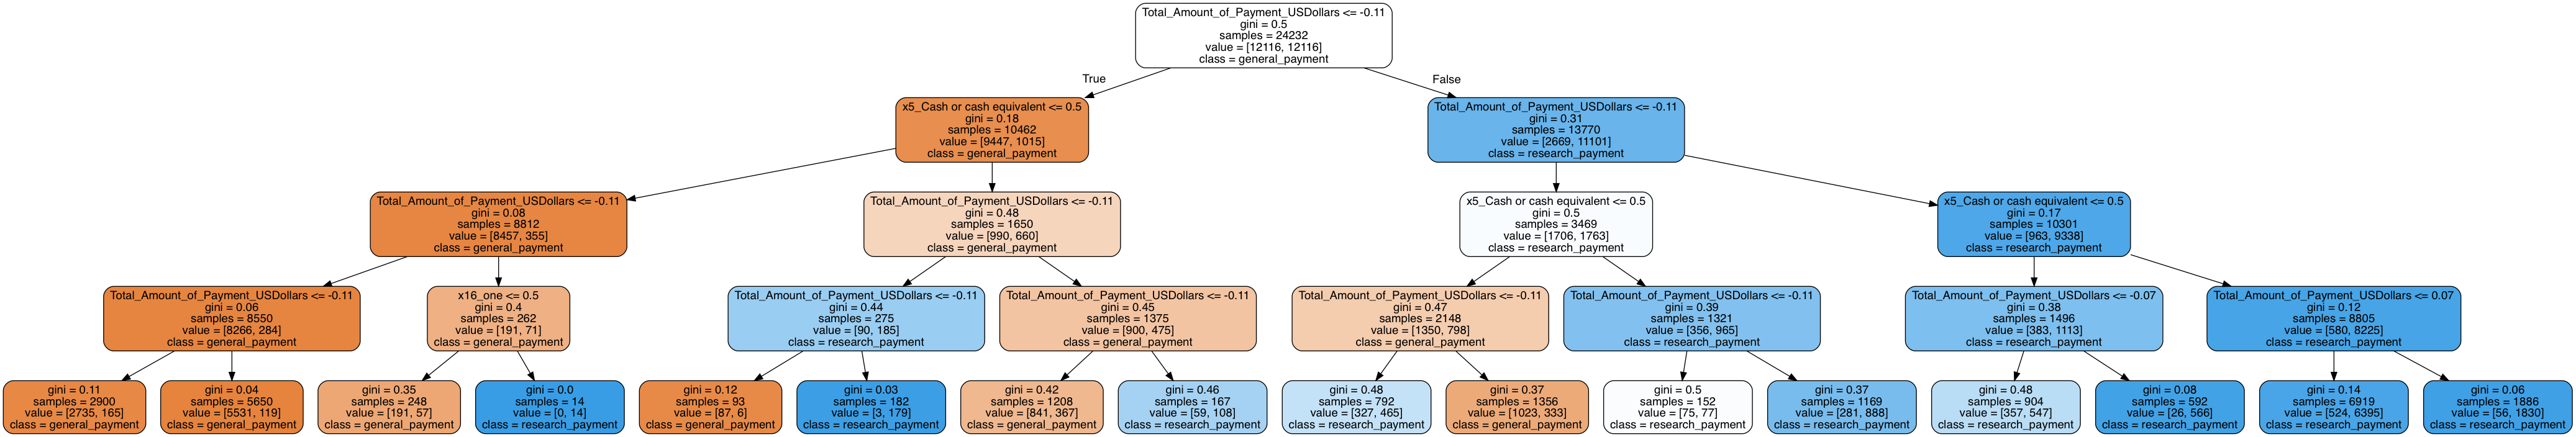

In [1244]:
from IPython.display import Image
Image(filename = 'tree.png')

In [1283]:
numeric_features = x_train_res2.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = x_train_res2.select_dtypes(include='object').columns.tolist()
# categorical_features.remove("type")
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=3))])

scores = cross_val_score(clf, x_train_res2, y_train_res2,scoring='f1_weighted')

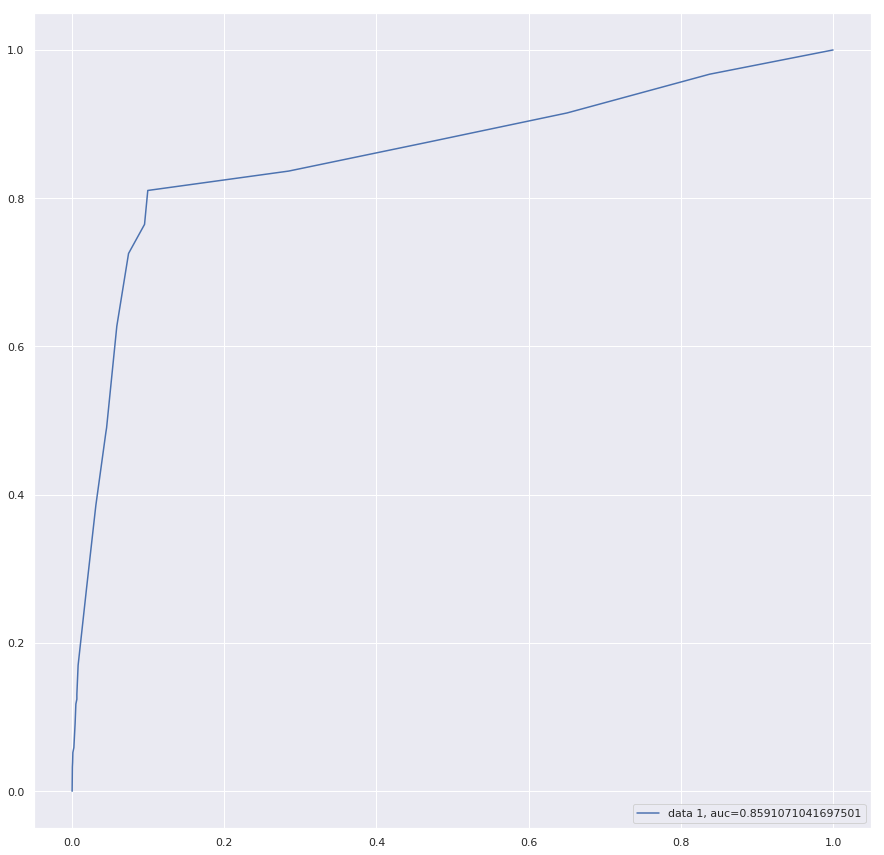

In [1284]:
proba = cross_val_predict(clf, X_val,y_val, cv=5, method='predict_proba')
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_val,  proba[::,1])
auc = metrics.roc_auc_score(y_val, proba[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC isn't so bad at 0.859. Our minimum viable model gives a decent performance.